In [1]:
# Import necessary library
from google.colab import drive, files
drive.mount('/content/drive')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# Downloading and extracting dataset
!wget -O /tmp/rockpaperscissors.zip https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
!unzip /tmp/rockpaperscissors.zip -d /tmp

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: /tmp/rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: /tmp/rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: /tmp/rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: /tmp/rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: /tmp/rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: /tmp/rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  

In [2]:
# Defining dataset location
dataset = '/tmp/rockpaperscissors/rps-cv-images'

In [3]:
# ImageDataGenerator for image augmentation on training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.4
)

# Just rescaling for validation data since they're not being used in the training
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4
)

In [5]:
# Set up generators to feed images from respective directories to the model, applying the defined augmentations
train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(150, 150),
    batch_size=16,
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    dataset,
    target_size=(150, 150),
    batch_size=16,
    subset='validation'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [6]:
# Setting model and compiling
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Stop training when validation loss fails to decrease and restore weights from the best epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# Reduce learning rate when validation loss plateaus for better adjustments
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.01, min_lr=0.00001)

# Model fitting
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    steps_per_epoch=25,
    validation_steps=5
)

Epoch 1/50
25/25 [==============================] - 35s 1s/step - loss: 1.1768 - accuracy: 0.3200 - val_loss: 1.0985 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 35s 1s/step - loss: 1.1006 - accuracy: 0.3050 - val_loss: 1.0971 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 33s 1s/step - loss: 1.0992 - accuracy: 0.3275 - val_loss: 1.1005 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 34s 1s/step - loss: 1.0930 - accuracy: 0.3400 - val_loss: 1.1235 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 32s 1s/step - loss: 1.0935 - accuracy: 0.3550 - val_loss: 1.1040 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 1.1022 - accuracy: 0.3500
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 [==============================] - 33s 1s/step - loss: 1.10

In [8]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

55/55 [==============================] - 18s 333ms/step - loss: 0.1066 - accuracy: 0.9703
Validation Accuracy: 97.03%


Saving sample.jpg to sample (2).jpg
1/1 [==============================] - 0s 40ms/step
sample (2).jpg

 [[1. 0. 0.]]

Predicted class: Paper



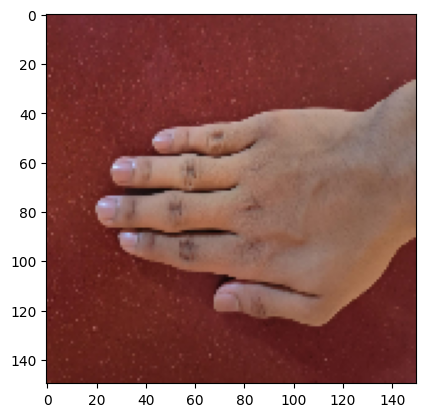

In [16]:
# Using model for image recognition on uploaded files

uploaded = files.upload()

class_names = ['Paper', 'Rock', 'Scissors']

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150, 150))

    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    predictions = model.predict(images, batch_size=10)
    print(fn)

    print('\n', predictions)

    class_index = np.argmax(predictions[0])

    print(f"\nPredicted class: {class_names[class_index]}\n")

In [ ]:
# Machine Learning Submission
# Nama: Abdul Fathin Fawwaz
# Email: abdulfathinfawwaz@gmail.com